# AML 3104: Assignment 2

## Used Car Price Prediction Using ML 

## Objective

You are given a dataset of used car listings. Your task is to build multiple regression models to predict the selling price of used cars based on features like age, brand, kilometers driven, fuel type, etc.
Compare the models based on performance, and save the best model for future deployment.

## Dataset

The dataset used in this project is sourced from Kaggle: [Used Car Price Prediction Dataset](https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset) (Najib, 2023). It contains 4,009 used car listings and 9 key features, originally scraped from [cars.com](https://www.cars.com). Each row represents a unique vehicle and includes relevant details used to model its resale value.

* **Brand & Model**: Brand name and model of the vehicle.
* **Model Year**: Year of manufacture — used to compute age and estimate depreciation.
* **Mileage**: Kilometers/miles driven — proxy for usage and condition.
* **Fuel Type**: Fuel category (e.g., gasoline, diesel, electric, hybrid).
* **Engine Type**: Basic engine info — helps assess performance/efficiency.
* **Transmission**: Manual or automatic.
* **Exterior & Interior Colors**: Aesthetic features for both interior and exterior.
* **Accident History**: Flags whether the vehicle has any recorded damage.
* **Clean Title**: Indicates if the title is clean, affecting resale and legal status.
* **Price**: Target column — the listed resale price of the car.

## Import libraries

In [1]:
%pip install -r "../requirements.txt"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from datetime import date

## 1. Data Preprocessing

### 1.1 Load the dataset and perform basic cleaning (handle missing values, duplicates).

In [3]:
# Define file path of the dataset
file_path = "../dataset/used_cars.csv"

# Load dataset into pandas DataFrame
df = pd.read_csv(file_path)

In [4]:
# Display first 5 rows of the df
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [5]:
# Check data types and non-null counts of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


In [6]:
# Check statistics summary of the df
df.describe()

,model_year
count,4009.000000
mean,2015.515590
std,6.104816
min,1974.000000
25%,2012.000000
50%,2017.000000
75%,2020.000000
max,2024.000000


In [7]:
# Check missing values for each column
df.isna().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

**Observations:**

* There are 170 missing values in `fuel_type` and 113 missing values in `accident`. 

* Meanwhile, `clean_title` has 596 missing values. I will further analyze whether to drop these records or replace them. 

<Axes: >

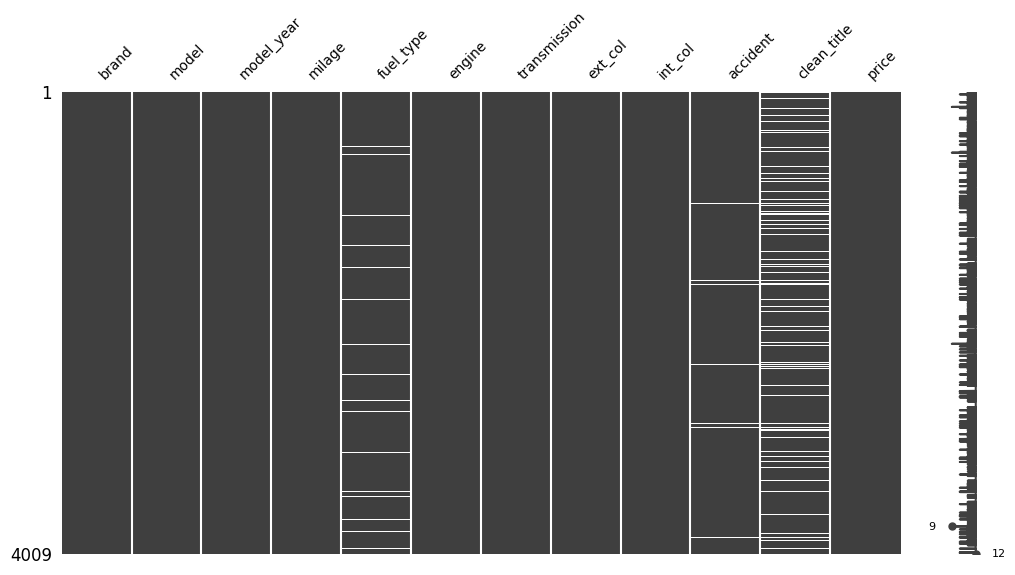

In [8]:
# Visualize missing values
msno.matrix(df, figsize=(12, 6), fontsize=10)

**Observations:**

* Based on the missing value matrix, there’s no correlation between columns that have missing values. The missing values appear randomly and are not dependent on each other.

* Since these columns are not linked, I can handle their missing values independently without introducing bias.

In [9]:
# Print unique values for each missing values column
missing_columns = df.columns[df.isna().any()]

for col in missing_columns:
    print(f"Unique values count of {col}: {df[col].nunique()}")
    print(f"{df[col].unique()}\n")

Unique values count of fuel_type: 7
['E85 Flex Fuel' 'Gasoline' 'Hybrid' nan 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']

Unique values count of accident: 2
['At least 1 accident or damage reported' 'None reported' nan]

Unique values count of clean_title: 1
['Yes' nan]



**Observations from Unique Values:**

* All three columns with missing values are categorical.

* `fuel_type` has 7 unique values including `'–'` and `'not supported'`. I’ll replace missing values, `'–'`, and `'not supported'` with `'Unknown'` to standardize the categories.

* `accident` has two values, including `'None reported'`. I’ll replace missing values with `'Unknown'`, but keep `'None reported'` as-is since it carries a specific and different meaning.

* `clean_title` only has `'Yes'`. I’ll fill missing values with `'Unknown'` since there’s no other alternative.

In [10]:
# Fill missing values with 'Unknown'
df['fuel_type'] = df['fuel_type'].fillna('Unknown')

In [11]:
# Standardize fuel types by replacing '–' and 'not supported' with 'Unknown'
df['fuel_type'] = df['fuel_type'].replace(['–', 'not supported'], 'Unknown')

In [12]:
# Verify the changes
df['fuel_type'].unique()

array(['E85 Flex Fuel', 'Gasoline', 'Hybrid', 'Unknown', 'Diesel',
       'Plug-In Hybrid'], dtype=object)

In [13]:
# Fill missing values with 'Unknown'
df['accident'] = df['accident'].fillna('Unknown')

In [14]:
# Verify the changes
df['accident'].unique()

array(['At least 1 accident or damage reported', 'None reported',
       'Unknown'], dtype=object)

In [15]:
# Fill missing values with 'Unknown'
df['clean_title'] = df['clean_title'].fillna('Unknown')

In [16]:
# Verify the changes
df['clean_title'].unique()

array(['Yes', 'Unknown'], dtype=object)

In [17]:
# Verify missing values
df.isna().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [20]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"Count of unique values in '{col}': {unique_count}")
    print(f"Unique values: {df[col].unique()}")
    print()

Count of unique values in 'brand': 57
Unique values: ['Ford' 'Hyundai' 'Lexus' 'INFINITI' 'Audi' 'Acura' 'BMW' 'Tesla' 'Land'
 'Aston' 'Toyota' 'Lincoln' 'Jaguar' 'Mercedes-Benz' 'Dodge' 'Nissan'
 'Genesis' 'Chevrolet' 'Kia' 'Jeep' 'Bentley' 'Honda' 'Lucid' 'MINI'
 'Porsche' 'Hummer' 'Chrysler' 'Volvo' 'Cadillac' 'Lamborghini' 'Maserati'
 'Volkswagen' 'Subaru' 'Rivian' 'GMC' 'RAM' 'Alfa' 'Ferrari' 'Scion'
 'Mitsubishi' 'Mazda' 'Saturn' 'Bugatti' 'Polestar' 'Rolls-Royce'
 'McLaren' 'Buick' 'Lotus' 'Pontiac' 'FIAT' 'Karma' 'Saab' 'Mercury'
 'Plymouth' 'smart' 'Maybach' 'Suzuki']

Count of unique values in 'model': 1898
Unique values: ['Utility Police Interceptor Base' 'Palisade SEL' 'RX 350 RX 350' ...
 'Martin DB7 Vantage Volante' 'Impala 2LZ' 'Taycan']

Count of unique values in 'milage': 2818
Unique values: ['51,000 mi.' '34,742 mi.' '22,372 mi.' ... '53,705 mi.' '714 mi.'
 '2,116 mi.']

Count of unique values in 'fuel_type': 6
Unique values: ['E85 Flex Fuel' 'Gasoline' 'Hybrid' 'Unkn

**Observations from Cardinality Check**

* `brand` has 57 unique values.

* `model` has 1,898 unique values, so it has extremely high cardinality. To handle this:

    * I’ll simplify it into `model_base` and one-hot encode it for **Linear Regression** and **Ridge Regression**, since these models can’t handle high-cardinality categorical features directly.

    * I’ll use the full `model` column as-is with **Label Encoding** for **Random Forest** and **XGBoost**, since these models can handle categorical splits natively when encoded as integers.

* `milage`, `engine`, `transmission`, `ext_col`, and `int_col` all have **very high cardinality** (60–2800+ values each). So, I will

    * clean inconsistent formats (e.g., "mi.", case, symbols)
    * extract normalized features (e.g., numeric mileage, HP from engine)
    * group rare values under `"Other"` for colors or trims

* `fuel_type`, `accident`, and `clean_title` have low cardinality (≤6). So, I will do one-hot encoding or label encoding.

* `transmission` has 62 unique values. Some values are formatting variants or junk (e.g., `"F"`, `"–"`, `"2"`). I will clean and standardize them. 

* `price` has 1,569 unique values. But I will remove `"$"` and `","` and convert them to float type.

### 1.2 Create a new feature: `car_age = current_year - year`.

In [ ]:
# Get current year using date.today().year
current_year = date.today().year
print(current_year)

2025


In [ ]:
# Check unique values of model year
df['model_year'].unique()

array([2013, 2021, 2022, 2015, 2016, 2017, 2001, 2020, 2019, 2003, 2018,
       2023, 2000, 2006, 2011, 2012, 2007, 2014, 2005, 2009, 2010, 2004,
       2008, 1997, 1999, 1993, 2002, 1998, 2024, 1996, 1974, 1992, 1995,
       1994])

In [ ]:
# Create new column to calculate car age
df['car_age'] = current_year - df['model_year']
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,car_age
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300",12
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005",4
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,Unknown,"$54,598",3
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500",10
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,Unknown,"$34,999",4


### 1.3 Drop irrelevant features like `car_name` if present.

TypeError: unhashable type: 'list'

In [ ]:
# Display all rows
pd.set_option("display.max_rows", None)

# Check unique values of car models
model_counts = df['model'].nunique()
print(model_counts)

1898


In [ ]:
# Check unique values of brand model pairs
print(df[['brand', 'model']].drop_duplicates().sort_values(['brand', 'model']))

              brand                                              model
234           Acura                         ILX 2.0L w/Premium Package
5             Acura                                           ILX 2.4L
1466          Acura                      ILX Premium & A-SPEC Packages
902           Acura                                ILX Premium Package
1458          Acura                        ILX Technology Plus Package
1681          Acura                                       Integra GS-R
387           Acura                                         Integra LS
216           Acura                      Integra w/A-Spec Tech Package
563           Acura                        MDX 3.5L Technology Package
731           Acura            MDX 3.5L w/Advance & Entertainment Pkgs
3071          Acura                      MDX 3.5L w/Technology Package
288           Acura                                   MDX 3.7L Advance
2766          Acura                                          MDX Sport
1933  

In [ ]:
# Count all model names that has brand name inside
df['brand_in_model'] = df.apply(lambda x: x['brand'] in x['model'], axis=1)
print(df['brand_in_model'].value_counts())

brand_in_model
False    3984
True       25
Name: count, dtype: int64


**Observations:**

* Only 25 rows out of 4,009 have the brand name inside the model string.

In [ ]:
df['model_tokens'] = df['model'].str.split()

In [ ]:
brand_tokens = df.groupby('brand')['model_tokens'].apply(list)
print(brand_tokens)

brand
Acura            [[ILX, 2.4L], [RL, Technology], [Integra, w/A-...
Alfa             [[Romeo, Stelvio, Ti, Sport], [Romeo, Giulia, ...
Aston            [[Martin, DBS, Superleggera], [Martin, DBS, Su...
Audi             [[Q3, 45, S, line, Premium, Plus], [S3, 2.0T, ...
BMW              [[740, iL], [440, Gran, Coupe, 440i, xDrive], ...
Bentley          [[Continental, GTC, Base], [Continental, GT, W...
Bugatti                             [[Veyron, 16.4, Grand, Sport]]
Buick            [[Verano, Convenience], [Encore, GX, Essence],...
Cadillac         [[CT5, Premium, Luxury], [CT5-V, Blackwing], [...
Chevrolet        [[S-10, LS], [Suburban, RST], [Silverado, 1500...
Chrysler         [[300, Touring], [300C, SRT8], [Pacifica, Tour...
Dodge            [[Challenger, SXT], [Ram, 1500, Laramie, Mega,...
FIAT             [[124, Spider, Abarth], [500e, Battery, Electr...
Ferrari          [[FF, Base], [Roma, Base], [California, T], [R...
Ford             [[Utility, Police, Interceptor, Base], 

In [ ]:
from collections import Counter

# Function to get most common starting token (or token pair)
def get_most_common_base(token_lists):
    prefix_counter = Counter()
    for tokens in token_lists:
        for i in range(1, min(len(tokens), 3)):  # check 1- and 2-token prefixes
            prefix = " ".join(tokens[:i])
            prefix_counter[prefix] += 1
    return prefix_counter.most_common(1)[0][0] if prefix_counter else None

# Apply to each brand
brand_to_model_base = brand_tokens.apply(get_most_common_base)

In [ ]:
df[df['brand'] == 'Toyota'][['brand', 'model', 'model_base', 'model_trim']].sort_values('model_base')

,brand,model,model_base,model_trim
230,Toyota,Highlander XLE,Highlander,XLE
3473,Toyota,Highlander XLE,Highlander,XLE
3341,Toyota,Highlander Hybrid Limited Platinum,Highlander,Hybrid Limited Platinum
3339,Toyota,Highlander Limited,Highlander,Limited
2938,Toyota,Highlander XLE,Highlander,XLE
2852,Toyota,Highlander XLE,Highlander,XLE
2696,Toyota,Highlander SE,Highlander,SE
2678,Toyota,Highlander Platinum,Highlander,Platinum
2666,Toyota,Highlander XLE,Highlander,XLE
2619,Toyota,Highlander Hybrid Limited,Highlander,Hybrid Limited


In [ ]:
def assign_base_and_trim(row):
    base = brand_to_model_base.get(row['brand'])
    if base and row['model'].startswith(base):
        return pd.Series([base, row['model'][len(base):].strip()])
    return pd.Series([None, row['model']])

df[['model_base', 'model_trim']] = df.apply(assign_base_and_trim, axis=1)

In [ ]:
# Print all token lists per brand
for brand, tokens in brand_tokens.items():
    print(f"\n{brand}")
    for token_list in tokens:
        print("  ", token_list)



Acura
   ['ILX', '2.4L']
   ['RL', 'Technology']
   ['Integra', 'w/A-Spec', 'Tech', 'Package']
   ['ILX', '2.0L', 'w/Premium', 'Package']
   ['TLX', 'w/A-Spec', 'Package']
   ['MDX', '3.7L', 'Advance']
   ['RSX', 'Type', 'S']
   ['Integra', 'LS']
   ['MDX', 'w/Technology', 'Package']
   ['RDX', 'Technology', 'Package']
   ['TLX', 'A-Spec']
   ['MDX', 'w/Technology', 'Package']
   ['MDX', '3.5L', 'Technology', 'Package']
   ['MDX', '3.7L', 'Advance']
   ['MDX', 'Technology']
   ['MDX', '3.5L', 'w/Advance', '&', 'Entertainment', 'Pkgs']
   ['ZDX', 'Base']
   ['RDX', 'Advance', 'Package']
   ['ILX', 'Premium', 'Package']
   ['TL', 'Technology']
   ['TLX', 'V6', 'Advance']
   ['ILX', 'Technology', 'Plus', 'Package']
   ['ILX', 'Premium', '&', 'A-SPEC', 'Packages']
   ['MDX', 'Technology']
   ['TLX', 'Type', 'S', 'w/Performance', 'Tire']
   ['RSX', 'Type', 'S']
   ['TL', '3.2']
   ['TLX', 'Base']
   ['TLX', 'PMC', 'Edition']
   ['Integra', 'GS-R']
   ['RDX', 'w/A-Spec', 'Package']
   ['RDX

In [ ]:
for brand, tokens in brand_tokens.items():
    print(f"\n{brand}")
    for t in tokens[:3]:  # change number as needed
        print("  ", t)



Acura
   ['ILX', '2.4L']
   ['RL', 'Technology']
   ['Integra', 'w/A-Spec', 'Tech', 'Package']

Alfa
   ['Romeo', 'Stelvio', 'Ti', 'Sport']
   ['Romeo', 'Giulia', 'Quadrifoglio']
   ['Romeo', 'Stelvio', 'Ti']

Aston
   ['Martin', 'DBS', 'Superleggera']
   ['Martin', 'DBS', 'Superleggera']
   ['Martin', 'DBX', 'Base']

Audi
   ['Q3', '45', 'S', 'line', 'Premium', 'Plus']
   ['S3', '2.0T', 'Premium', 'Plus']
   ['Q5', '2.0T', 'Premium', 'Plus']

BMW
   ['740', 'iL']
   ['440', 'Gran', 'Coupe', '440i', 'xDrive']
   ['650', 'Gran', 'Coupe', 'i', 'xDrive']

Bentley
   ['Continental', 'GTC', 'Base']
   ['Continental', 'GT', 'W12']
   ['Arnage', 'R']

Bugatti
   ['Veyron', '16.4', 'Grand', 'Sport']

Buick
   ['Verano', 'Convenience']
   ['Encore', 'GX', 'Essence']
   ['Rainier', 'CXL']

Cadillac
   ['CT5', 'Premium', 'Luxury']
   ['CT5-V', 'Blackwing']
   ['CT5-V', 'V-Series']

Chevrolet
   ['S-10', 'LS']
   ['Suburban', 'RST']
   ['Silverado', '1500', 'Custom', 'Trail', 'Boss']

Chrysler
  

### 1.4 Convert categorical variables using One-Hot Encoding or Label Encoding.

### 1.5 Normalize or scale the features where needed.

## 2. Exploratory Data Analysis

### 2.1 Visualize Price Distribution, Correlations, and Key Relationships

### 2.2 Boxplots for Categorical Features vs. `selling_price`

### 2.3 Histograms and Scatter Plots for Numerical Features

## 3. Model Building

### 3.1 Linear Regression

### 3.2 Ridge Regression

### 3.3 Random Forest Regressor

### 3.4 XGBoost Regressor (Optional: use LightGBM or any other advanced model)

## 4. Model Evaluation

### 4.1 Evaluate each model using:
- R² Score
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

### 4.2 Use cross-validation (e.g., 5-fold) to ensure generalization.

## 5. Model Selection

### 5.1 Select the best model based on lowest RMSE and highest R².

### 5.2 Show a comparison table for model performance.

## 6. Save the Best Model

### 6.1 Use `joblib` or `pickle` to save the best-performing model.

## References

* Najib, T. (2023). Used Car Price Prediction Dataset. [online] Kaggle.com. Available at: https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset?utm_source=chatgpt.com&select=used_cars.csv [Accessed 16 Jun. 2025].

* Python Documentation. (2019). datetime — Basic date and time types. [online] Available at: https://docs.python.org/3/library/datetime.html#datetime.date.year [Accessed 16 Jun. 2025].

* Pandas 1.4.1 Documentation. (2025). Options and Settings. [online] Available at: https://pandas.pydata.org/docs/user_guide/options.html [Accessed 16 Jun. 2025].